In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
%matplotlib inline

from auxiliary import get_base_network_name
from mpl_settings_v3 import *

net_dir = '../networks/ER'

In [22]:
def load_dataframe(attack, size, param, net_type='ER', fast=False, n_seeds=None):
    dir_name = os.path.join('../networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    if fast:
        base_csv_file_name = '{}_nSeeds{:d}_cpp.csv'.format(attack, n_seeds)
    else:
        base_csv_file_name = '{}_cpp.csv'.format(attack)
    csv_file_name = os.path.join(dir_name, base_net_name, base_net_name_size, base_csv_file_name)
    df = pd.read_csv(csv_file_name, index_col=0)
    return df

attack = 'Deg'
meank = 5
N_values = [250, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000]
compare_fast = False
if compare_fast:
    dfs = {}
    for N in N_values:
        df = load_dataframe(attack, N, meank)
        dfs[N] = df

    fast_dfs = {}
    for N in N_values:
        df = load_dataframe(attack, N, meank, fast=True, n_seeds=10000)
        fast_dfs[N] = df
        
else:
    dfs1000 = {}
    dfs10000 = {}
    dfs20000 = {}
    for N in N_values:
        dfs1000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=1000)
        try:
            dfs10000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=10000)
        except:
            pass
        try:
            dfs20000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=20000)
        except:
            pass
        
dfsMax = {}
for N in N_values:
    if N in dfs20000:
        dfsMax[N] = dfs20000[N]
    elif N in dfs10000:
        dfsMax[N] = dfs10000[N]
    else:
        dfsMax[N] = dfs1000[N]

KeyError: 64000

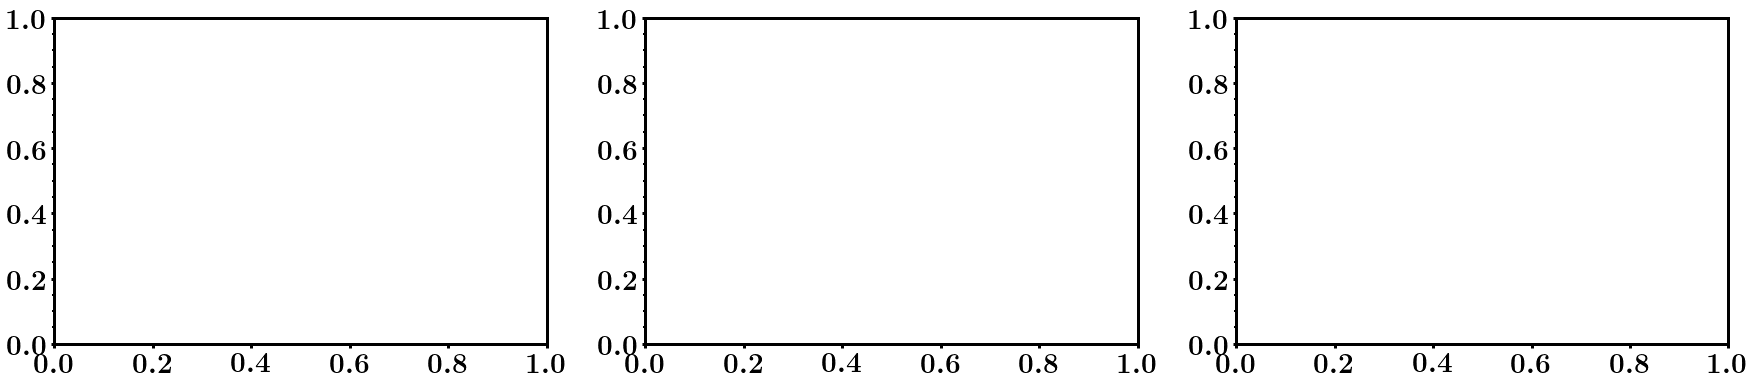

In [649]:
ncols = 3
fig, axes = plt.subplots(figsize=(10*ncols, 6), ncols=ncols)

ax = axes[0]
for df in [dfs[N], fast_dfs[N]]:
    ax.plot(df.f, df.Nsec)
ax.set_xlim(0.65, 0.85)
ax.set_ylim(5, 11)

ax = axes[1]
for df in [dfs[N], fast_dfs[N]]:
    ax.plot(df.f, df.meanS)
ax.set_xlim(0.65, 0.85)
ax.set_ylim(2, 4)

ax = axes[2]
for df in [dfs[N], fast_dfs[N]]:
    ax.plot(df.f, df.varSgcc)
ax.set_xlim(0.65, 0.85)
#ax.set_ylim(2, 4)

plt.show()

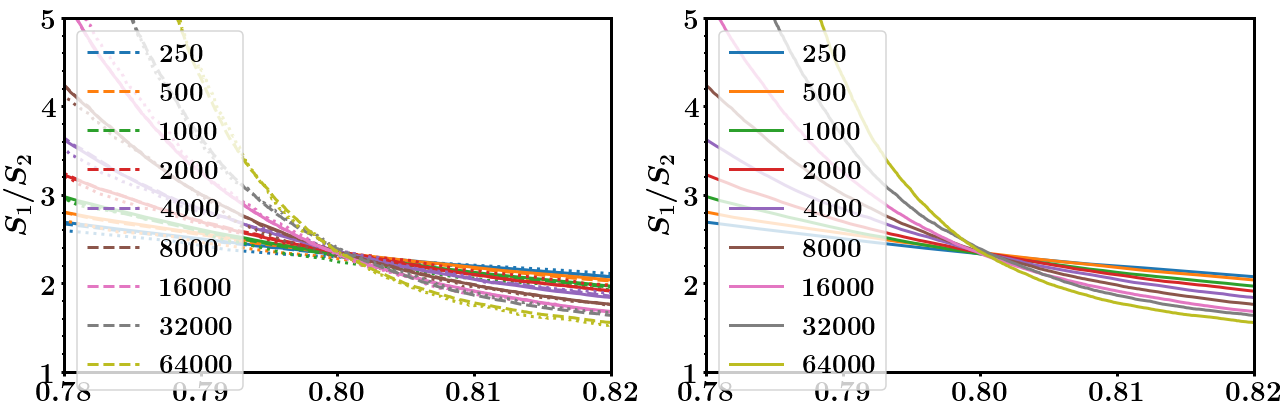

In [650]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ncols = 2
fig, axes = plt.subplots(figsize=(9*ncols, 6), ncols=ncols)

for ax in axes:
    if attack == 'Ran':
        fmin = 0.75
        fmax = 0.87
        fmin = 0.78
        fmax = 0.82
        ax.set_ylim(1, 5)
    if attack == 'Deg':
        fmin = 0.44
        fmax = 0.49
        ax.set_ylim(1.4, 4)
    if attack == 'DegU':
        fmin = 0.334
        fmax = 0.345
        ax.set_ylim(2, 4)
    if attack == 'Btw':
        fmin = 0.5
        fmax = 0.6
        ax.set_ylim(1, 3)
    ax.set_xlim(fmin, fmax)
    ax.set_ylabel(r'$S_1/S_2$')

for i, N in enumerate(N_values):

    df = dfs1000[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    axes[0].plot(df.f, S1_over_S2, ':', color=colors[i])
    
    df = dfs10000[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    axes[0].plot(df.f, S1_over_S2, '--', label=r'${{{}}}$'.format(N), color=colors[i])
    
    try:
        df = dfs20000[N]
        S1_over_S2 = N * df.Sgcc / df.Nsec
        axes[0].plot(df.f, S1_over_S2, '-', color=colors[i])
    except:
        pass
    
    df = dfsMax[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    axes[1].plot(df.f, S1_over_S2, '-', label=r'${{{}}}$'.format(N), color=colors[i])
    
#ax.axvline(0.8, linestyle='--', color='k')
for ax in axes:
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [651]:
def compute_fc_v2(dfs, min_f, max_f):

    N_values = sorted(list(dfs.keys()))
    
    
    N1_over_N2 = {}
    for N in N_values:
        N1_over_N2[N] = ((N*dfs[N]['Sgcc'])/dfs[N]['Nsec']).values

    max_N = N_values[-1]
    mask = np.arange(int(min_f*max_N), int(max_f*max_N))
    n_values = len(mask)
    x = dfs[max_N]['f'][mask].values
    inter_values = []
    s = np.zeros(n_values)
    for Na in N_values:
        for Nb in N_values:
            if Nb <= Na:
                continue
            mask = np.arange(int(min_f*Na), int(max_f*Na))
            xp = dfs[Na]['f'][mask].values
            fp = N1_over_N2[Na][mask]
            Na_values = np.interp(x, xp, fp)

            mask = np.arange(int(min_f*Nb), int(max_f*Nb))
            xp = dfs[Nb]['f'][mask].values
            fp = N1_over_N2[Nb][mask]
            Nb_values = np.interp(x, xp, fp)
            s += np.fabs(1 - Na_values/Nb_values)
            inter = np.argmin(s)/max_N
            inter_values.append(inter)
    mean_inter = np.mean(inter_values)
    std_inter = np.std(inter_values)
    fc = min_f + mean_inter
    return fc, std_inter

print('{:.4f} {:.4f}'.format(*compute_fc_v2(dfs1000, fmin, fmax)))
print('{:.4f} {:.4f}'.format(*compute_fc_v2(dfs10000, fmin, fmax)))
print('{:.4f} {:.4f}'.format(*compute_fc_v2(dfs20000, fmin, fmax)))
print('{:.4f} {:.4f}'.format(*compute_fc_v2(dfsMax, fmin, fmax)))

0.8009 0.0010
0.8011 0.0009
0.8005 0.0011
0.8006 0.0008


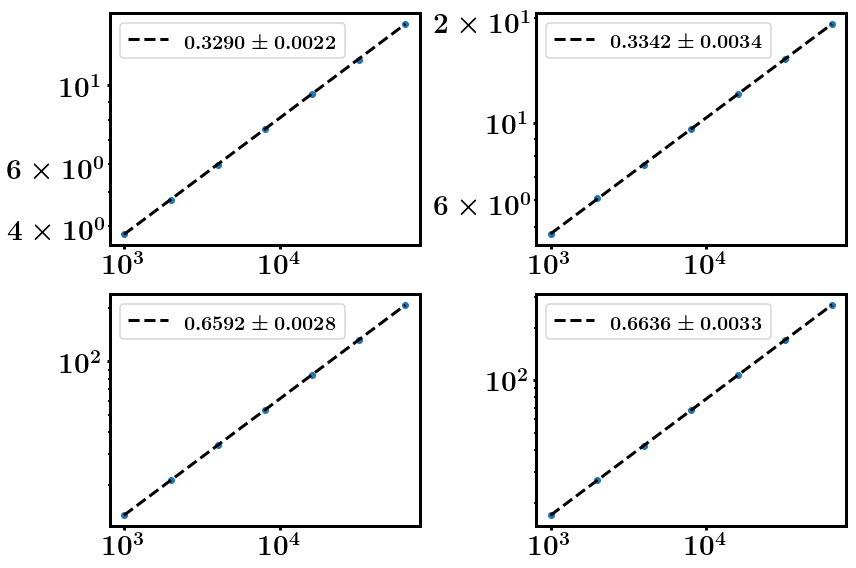

In [657]:
from sklearn.linear_model import LinearRegression

def getPeaks(dfs, measure):
    N_values = sorted(dfs.keys())
    
    fc_values  = []
    max_values = []
        
    for i, N in enumerate(N_values):
        df = dfs[N]
        max_idx = df[measure].idxmax()
        max_value = df[measure][max_idx]
        
        fc_values.append(max_idx/N)
        max_values.append(max_value)
        
    return fc_values, max_values

def get_critical_measures(dfs, measure, fc):
    
    N_values = sorted(dfs.keys())
    
    if fc == 'peak':
        fc_values, _ = getPeaks(dfs, measure)
    elif isinstance(fc, float): 
        fc_values = [fc] * len(N_values)
    else:
        print('ERROR')
        
    crit_values = []    
    for i, N in enumerate(N_values):
        df = dfs[N]
        fc = fc_values[i]
            
        if measure == 'Sgcc':
            crit_values.append(N*df[measure][int(fc*N)])
        else:
            crit_values.append(df[measure][int(fc*N)])
        
    return np.array(crit_values)  

def powerlaw(X, a, c):
    return c*np.array(X)**a

def getLinearReg(sizes, values, return_r2=False):

    X = np.log(sizes)
    Y = np.log(values)
    coeffs, cov = np.polyfit(X, Y, 1, cov=True)
    errors = np.sqrt(np.diag(cov))
    
    intercept = coeffs[1]
    slope = coeffs[0]
    y_error = 3*errors[0] ## Use three times standard error
    Y_pred = intercept + X*slope
    
    if return_r2:
        return np.exp(Y_pred), slope, linear_regressor.score(X, Y)
    return np.exp(Y_pred), slope, y_error

dfs = copy.deepcopy(dfsMax)
del dfs[250]
del dfs[500]
#del dfs[1000]
N_values = list(dfs.keys())

fc = compute_fc_v2(dfs, fmin, fmax)[0]
#fc = 0.8

measures = ['meanS', 'Nsec']

ncols = 2
nrows = 2
fig, axes_cols = plt.subplots(figsize=(6*ncols, 4*nrows), ncols=ncols, nrows=2)

for i, measure in enumerate(measures):

    axes = axes_cols[i]
    
    measure_values = get_critical_measures(dfs, measure, fc)
    Y_pred, slope, y_err = getLinearReg(N_values, measure_values)
    ax = axes[0]
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(N_values, measure_values, 'o')
    ax.plot(N_values, Y_pred, '--', color='k', label=r'${{{:.4f}}}\pm{{{:.4f}}}$'.format(slope, y_err))
    ax.legend(loc='best', fontsize=20)

    measure_values = get_critical_measures(dfs, measure, fc='peak')
    Y_pred, slope, y_err = getLinearReg(N_values, measure_values)
    ax = axes[1]
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(N_values, measure_values, 'o')
    ax.plot(N_values, Y_pred, '--', color='k', label=r'${{{:.4f}}}\pm{{{:.4f}}}$'.format(slope, y_err))
    ax.legend(loc='best', fontsize=20)
plt.tight_layout()
plt.show()

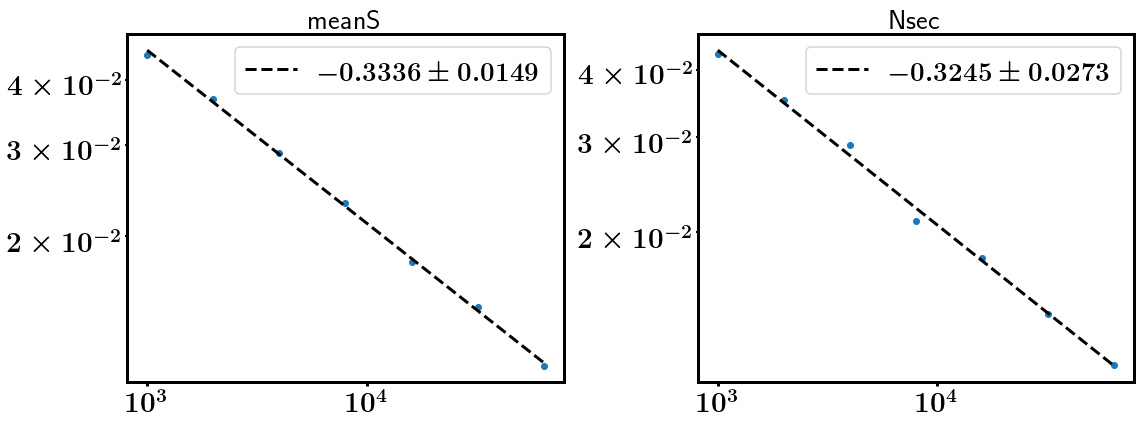

In [656]:
fig, axes = plt.subplots(figsize=(8*ncols, 6), ncols=ncols)
for i, measure in enumerate(measures):
    ax = axes[i]
    ax.set_title(measure, fontsize=28)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    fc_mean, fc_std = compute_fc_v2(dfs, fmin, fmax)
    #fc_mean = 0.465
    #fc_mean = 0.8
    fc_values, peak_values = getPeaks(dfs, measure)
    fc_diff = fc_mean - np.array(fc_values)

    ax.plot(N_values, fc_diff, 'o')
    Y_pred, slope, y_err = getLinearReg(N_values, fc_diff)
    
    ax.plot(N_values, Y_pred, '--', color='k', label=r'${{{:.4f}}}\pm{{{:.4f}}}$'.format(slope, y_err))
    ax.legend()
plt.tight_layout()
plt.show()

In [343]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a - b*x**(c)

curve_fit(func, N_values, fc_values, p0=[1, 1, -0.33])

(array([ 0.80645082,  0.30236627, -0.26418577]),
 array([[ 0.0001091 , -0.00121998,  0.00089389],
        [-0.00121998,  0.01447107, -0.01033418],
        [ 0.00089389, -0.01033418,  0.00746449]]))

In [301]:
fc_mean, fc_std = compute_fc_v2(dfs, fmin, fmax)
fc_values = np.linspace(fc_mean-2*fc_std, fc_mean+2*fc_std, 100)
print('{:.4f} {:.4f}'.format(fc_mean, fc_std), end='\n\n')
for i, measure in enumerate(['meanS', 'Nsec']):
    for fc in fc_values:
        measure_values = get_critical_measures(dfs, measure, fc)
        Y_pred, slope, y_err = getLinearReg(N_values, measure_values)
        
        print('{:.5f} {:.5f} {:.5f}'.format(fc, slope, y_err))
    print()

0.4654 0.0003

0.46486 0.35326 0.00194
0.46487 0.35326 0.00194
0.46489 0.35272 0.00246
0.46490 0.35272 0.00246
0.46491 0.35259 0.00230
0.46492 0.35259 0.00230
0.46493 0.35259 0.00230
0.46494 0.35202 0.00236
0.46495 0.35202 0.00236
0.46497 0.35202 0.00236
0.46498 0.35177 0.00210
0.46499 0.35177 0.00210
0.46500 0.35412 0.00262
0.46501 0.35412 0.00262
0.46502 0.35412 0.00262
0.46503 0.35392 0.00261
0.46505 0.35392 0.00261
0.46506 0.35392 0.00261
0.46507 0.35349 0.00289
0.46508 0.35349 0.00289
0.46509 0.35349 0.00289
0.46510 0.35323 0.00293
0.46511 0.35323 0.00293
0.46513 0.35259 0.00330
0.46514 0.35259 0.00330
0.46515 0.35259 0.00330
0.46516 0.35235 0.00329
0.46517 0.35235 0.00329
0.46518 0.35235 0.00329
0.46519 0.35173 0.00358
0.46521 0.35173 0.00358
0.46522 0.35173 0.00358
0.46523 0.35146 0.00364
0.46524 0.35146 0.00364
0.46525 0.35122 0.00323
0.46526 0.35122 0.00323
0.46527 0.35122 0.00323
0.46529 0.35107 0.00324
0.46530 0.35107 0.00324
0.46531 0.35107 0.00324
0.46532 0.35057 0.00345
0

In [6]:
import igraph as ig
def getMeanK(N, minSeed, maxSeed):
    base_data_dir = '../networks/ER/ER_k5.00/ER_k5.00_N{N}'.format(N=N)
    k_values = []
    k2_values = []
    for seed in range(minSeed, maxSeed):
        network = 'ER_k5.00_N{}_{:05d}'.format(N, seed)
        file_name = os.path.join(base_data_dir, network, network + '.txt')
        g = ig.Graph().Read_Edgelist(file_name, directed=False)
        #print(data_dir)
        degSeq = np.array(g.degree())
        k_values.append(degSeq.mean())
        k2_values.append(np.mean(degSeq**2))
    k_values = np.array(k_values)
    k2_values = np.array(k2_values)
    return k_values.mean(), k2_values.mean(), k_values.std()
minSeed = 0
maxSeed = 1000
N = 8000
meank, meank2, stdk = getMeanK(N, minSeed, maxSeed)

In [7]:
print(meank, np.sqrt(meank2), stdk)

4.997051349262408 5.4740202769364625 0.03480124444828066


In [8]:
1 - 1/(meank2/meank - 1)

0.7998605398093651

In [9]:
def pk(k, c):
    return np.exp(-c) * c**k / np.math.factorial(k)

def Pk(kmax, c):
    s = 0
    for k in range(kmax):
        s += pk(k, c)
    return s

def F0(z, kmax, c):
    s = 0
    for k in range(kmax):
        s += pk(k, c) * z**k
    return s

def F1(z, kmax, c):
    s = 0
    for k in range(1, kmax):
        s += k*pk(k, c) * z**(k-1)
    return s / c

kmax = 4
c = 4
print(F0(1, kmax, c))
F1(1, kmax, c)

0.43347012036670884


0.2381033055535443

In [10]:
c = 5
Pk_values = []
S_values = []
for kmax in range(1, 20):
    u = 0.5
    for i in range(1000):
        u = 1 - F1(1, kmax, c) + F1(u, kmax, c)
        #print(i, u)

    S = F0(1, kmax, c) - F0(u, kmax, c)
    print(kmax, Pk(kmax, c), 'S =', S)
    
    Pk_values.append(Pk(kmax, c))
    S_values.append(S)
    
Pk_values = np.array(Pk_values)
S_values = np.array(S_values)

1 0.006737946999085467 S = 0.0
2 0.040427681994512805 S = 0.0
3 0.12465201948308113 S = 0.0
4 0.2650259152973617 S = 0.0
5 0.4404932850652124 S = 2.7755575615628914e-16
6 0.6159606548330632 S = 0.3679873380738437
7 0.7621834629729387 S = 0.7004291054769073
8 0.8666283259299927 S = 0.8415468176389116
9 0.9319063652781515 S = 0.9178224549179795
10 0.9681719426937953 S = 0.9582177439519501
11 0.9863047314016171 S = 0.9780725033108503
12 0.9945469080869906 S = 0.9870560300998233
13 0.997981148372563 S = 0.9908039677003648
14 0.99930201002086 S = 0.9922514844363343
15 0.9997737463238233 S = 0.992771315255627
16 0.9999309917581444 S = 0.9929456547974044
17 0.9999801309563697 S = 0.9930004824176687
18 0.9999945836617301 S = 0.9930167117704075
19 0.999998598302108 S = 0.9930212488649491


In [51]:
def Pk(kmax, c):
    s = 0
    for k in range(kmax):
        s += pk(k, c)
    return 1 - s

def pk(k, c):
    return np.exp(-c) * c**k / np.math.factorial(k)

def pk_f(k, c, f):
    if f < Pk(k+1, c):
        return pk(k,c)
    elif f >= Pk(k, c):
        return 0
    return Pk(k, c)-f

def F0new(x, f, c, mode=None):
    s = 0
    k = 0
    while True:
        pk_f_value = pk_f(k, c, f)
        if pk_f_value == 0:
            break
        s +=  pk_f_value * x**k
        k += 1
    return s

def F1new(x, f, c, mode=None):
    s = 0
    k = 1
    while True:
        pk_f_value = pk_f(k, c, f)
        if pk_f_value == 0:
            break
        s +=  k * pk_f_value * x**(k-1)
        k += 1
    return s / c

def F1primaNew(x, f, c, mode=None):
    s = 0
    k = 2
    while True:
        pk_f_value = pk_f(k, c, f)
        if pk_f_value == 0:
            break
        s +=  k * (k-1) * pk_f_value * x**(k-2)
        k += 1
    return s / c

c = 5
it_values = 100
kmax_values = np.arange(it_values)
S_values_f = np.zeros(it_values)
meanS_values_f = np.zeros(it_values)
f_values_f = np.linspace(0.2, 0.8, it_values)

for i, f in enumerate(f_values_f):

    u = 0.5    
    for _ in range(1, 100):
        u = 1 - F1new(1, f, c) + F1new(u, f, c)
    S = F0new(1, f, c) - F0new(u, f, c)
    print('{:.5f} {:.5f}'.format(f, c*F1_prima_new(u, f, c)))
    S_values_f[i] = S
    
    meanS = (F0new(u, f, c) + c*F1new(u, f, c)*F1new(u, f, c))/((1-S)*(1-F1primaNew(u, f, c)))
    
    meanS_values_f[i] = meanS
    #print('{:.3f} {:.3f} {:.3f}'.format(f, S, u))

0.20000 0.26541
0.20606 0.27863
0.21212 0.29253
0.21818 0.30714
0.22424 0.32250
0.23030 0.33865
0.23636 0.35563
0.24242 0.37072
0.24848 0.38550
0.25455 0.40080
0.26061 0.41666
0.26667 0.43308
0.27273 0.45009
0.27879 0.46771
0.28485 0.48595
0.29091 0.50484
0.29697 0.52440
0.30303 0.54466
0.30909 0.56564
0.31515 0.58736
0.32121 0.60986
0.32727 0.63316
0.33333 0.65730
0.33939 0.68231
0.34545 0.70823
0.35152 0.73509
0.35758 0.76293
0.36364 0.79180
0.36970 0.82175
0.37576 0.85282
0.38182 0.88506
0.38788 0.91168
0.39394 0.93496
0.40000 0.95873
0.40606 0.98302
0.41212 1.00782
0.41818 1.03316
0.42424 1.05904
0.43030 1.08548
0.43636 1.11250
0.44242 1.14009
0.44848 1.16816
0.45455 1.19589
0.46061 1.21885
0.46667 1.22531
0.47273 1.20947
0.47879 1.18221
0.48485 1.15232
0.49091 1.12206
0.49697 1.09176
0.50303 1.06146
0.50909 1.03115
0.51515 1.00085
0.52121 0.97055
0.52727 0.94025
0.53333 0.90994
0.53939 0.87964
0.54545 0.84934
0.55152 0.81903
0.55758 0.78873
0.56364 0.76669
0.56970 0.74850
0.57576 

In [20]:
def F0(x, f, c, mode=None):
    s = 0
    k = 0
    while True:
        q = threshold(k, f, c, mode=mode)
        if q == 0:
            break
        s += pk(k, c) * q * x**k
        print('{:2d} {:.5f} {:.5f} {:.5f}'.format(k, s, pk(k, c), pk(k, c) * q))
        k += 1
    return s

F0(1, 0.6, c)

NameError: name 'threshold' is not defined

In [16]:
def pk_f(k, c, f):
    if f < Pk(k+1, c):
        #print('first')
        #return pk(k,c)/(1-f)
        return pk(k,c)
    elif f >= Pk(k, c):
        #print('sec')
        return 0
    #print('third')
    #return (1-Pk(k, c))/(1-f)
    return Pk(k, c)-f

def F0new(x, f, c, mode=None):
    s = 0
    k = 0
    while True:
        pk_f_value = pk_f(k, c, f)
        if pk_f_value == 0:
            break
        s +=  pk_f_value * x**k
        print('{:2d} {:.5f} {:.5f}'.format(k, s, pk_f_value))
        k += 1
    return s

F0new(1, 0.6, c)

 0 0.00674 0.00674
 1 0.04043 0.03369
 2 0.12465 0.08422
 3 0.26503 0.14037
 4 0.40000 0.13497


0.39999999999999997

In [47]:
c = 4
for i, f in enumerate(np.linspace(0.36, 0.362, 20)):
   
    u_prev = u = 0.9 
    for _ in range(1, 10000):
        u = 1 - F1new(1, f, c) + F1new(u, f, c)
        delta_u = np.fabs(u_prev - u)
        u_prev = u
        if delta_u < 10E-10:
            break
    F1prima_value = F1primaNew(u, f, c)
    print('{:.5f} {:.5f} {:.5f}'.format(f, u, F1prima_value))




0.36000 0.98989 0.99180
0.36011 0.99053 0.99232
0.36021 0.99117 0.99284
0.36032 0.99181 0.99337
0.36042 0.99245 0.99389
0.36053 0.99310 0.99441
0.36063 0.99374 0.99494
0.36074 0.99439 0.99546
0.36084 0.99503 0.99599
0.36095 0.99568 0.99651
0.36105 0.99633 0.99704
0.36116 0.99698 0.99756
0.36126 0.99763 0.99809
0.36137 0.99828 0.99861
0.36147 0.99893 0.99914
0.36158 0.99957 0.99964
0.36168 0.99996 0.99974
0.36179 1.00000 0.99928
0.36189 1.00000 0.99875
0.36200 1.00000 0.99823


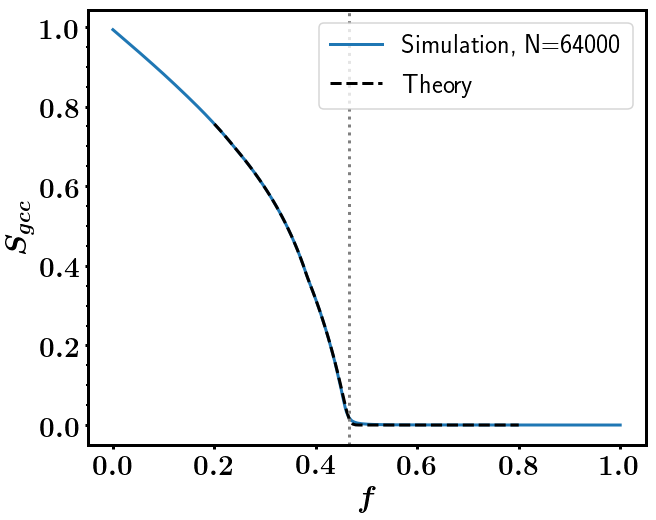

In [28]:
#plt.plot(dfsMax[1000].f, dfsMax[1000].Sgcc)
plt.figure(figsize=(10, 8))
plt.plot(dfsMax[64000].f, dfsMax[64000].Sgcc, '-', label='Simulation, N=64000')
#plt.plot(1-Pk_values, S_values, 's')
plt.plot(f_values_f, S_values_f, '--', color='k', label='Theory')
plt.xlabel(r'$f$')
plt.ylabel(r'$S_{gcc}$')
plt.axvline(0.465, linestyle=':', color='grey')
plt.legend()
plt.show()

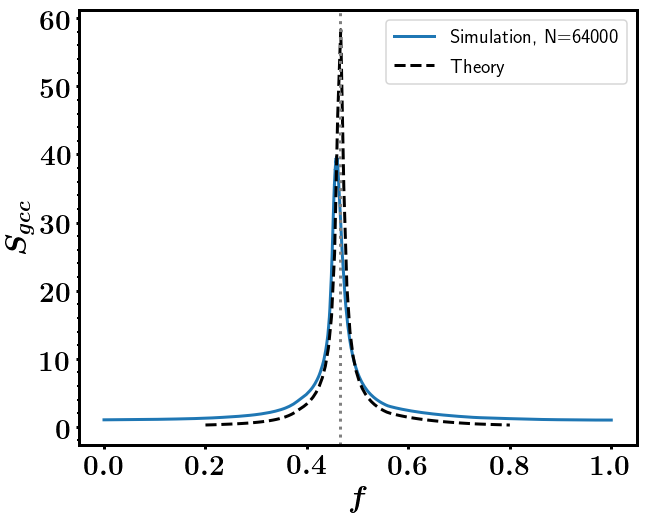

In [54]:
#plt.plot(dfsMax[1000].f, dfsMax[1000].Sgcc)
plt.figure(figsize=(10, 8))
plt.plot(dfsMax[64000].f, dfsMax[64000].meanS, '-', label='Simulation, N=64000')
#plt.plot(1-Pk_values, S_values, 's')
plt.plot(f_values_f, meanS_values_f, '--', color='k', label='Theory')
plt.xlabel(r'$f$')
plt.ylabel(r'$S_{gcc}$')
plt.axvline(0.465, linestyle=':', color='grey')
plt.legend(loc='best', fontsize=20)
plt.show()

In [627]:
def Pk(kmax, c):
    s = 0
    for k in range(kmax):
        s += pk(k, c)
    return 1 - s

def threshold(k, f, c, mode=None):
    if mode == 'kmax':
        if k < kmax:
            return 1
        return 0
    else:
        if f > Pk(k, c):
            return 0
        elif f < Pk(k+1, c):
            return 1
        return (Pk(k, c) - f) / pk(k, c)

def F0(x, f, c, mode=None):
    s = 0
    k = 0
    while True:
        q = threshold(k, f, c, mode=mode)
        if q == 0:
            break
        s += pk(k, c) * q * x**k
        k += 1
    return s

def F1(x, f, c, mode=None):
    s = 0
    k = 1
    while True:
        q = threshold(k, f, c, mode=mode)
        if q == 0:
            break
        s += k * pk(k, c) * q * x**(k-1)
        k += 1
    return s / c

c = 5
it_values = 100
kmax_values = np.arange(it_values)
S_values_f = np.zeros(it_values)
#f_values = np.zeros(it_values)
f_values_f = np.linspace(0.2, 0.8, it_values)
for i, f in enumerate(f_values_f):

    u = 0.5    
    for _ in range(1, 100):
        u = 1 - F1(1, f, c) + F1(u, f, c)
    S = F0(1, f, c) - F0(u, f, c)
        
    S_values_f[i] = S
    #print('{:.3f} {:.3f} {:.3f}'.format(f, S, u))
    
kmax_values = np.arange(it_values)
S_values = np.zeros(it_values)
f_values = []
for i, kmax in enumerate(kmax_values):

    u = 0.5
    #f = kmax
    
    for _ in range(1, 50):
        u = 1 - F1(1, f, c, mode='kmax') + F1(u, f, c, mode='kmax')
    S = F0(1, f, c, mode='kmax') - F0(u, f, c, mode='kmax')
        #print(i, S)
        
    S_values[i] = S
    f_values.append(Pk(kmax, c)) 

In [620]:
seed = 0
N = 64000
base_data_dir = '../networks/ER/ER_k5.00/ER_k5.00_N{N}'.format(N=N)
network = 'ER_k5.00_N{}_{:05d}'.format(N, seed)
file_name = os.path.join(base_data_dir, network, network + '.txt')
g = ig.Graph().Read_Edgelist(file_name, directed=False)

btw = g.betweenness()
degSeq = g.degree()
data = list(zip(range(N), degSeq, btw))
data = np.array(data)

KeyboardInterrupt: 

15.0 4
14.0 23
13.0 34
12.0 117
11.0 253
10.0 575
9.0 1171
8.0 2042
7.0 3316
6.0 4656
5.0 5625
4.0 5604
3.0 4549
2.0 2675


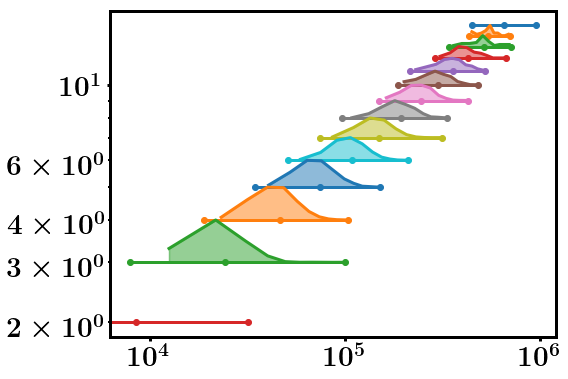

In [537]:
df = pd.DataFrame(data, columns=['id', 'k', 'b'])
fig, ax = plt.subplots(figsize=(8, 6))
#ax.set_xscale('log')
for i, k in enumerate(sorted(df.k.unique(), reverse=True)):
    if k < 2:
        continue
    color = colors[i%len(colors)]
    btw = df[df.k==k].b
    values = [btw.min(), btw.mean(), btw.max()]
    ax.plot(values, [k]*len(values), '-o', color=color)
    print(k, len(btw))
    if len(btw) > 20 and btw.min() > 0:
        hist, bin_edges = np.histogram(btw, density=True)
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        ax.plot(bin_centers, (hist)/max(hist) + k, color=color)
        ax.fill_between(bin_centers, hist/max(hist)+k, k, color=color, alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()    

Help on function sort in module numpy:

sort(a, axis=-1, kind='quicksort', order=None)
    Return a sorted copy of an array.
    
    Parameters
    ----------
    a : array_like
        Array to be sorted.
    axis : int or None, optional
        Axis along which to sort. If None, the array is flattened before
        sorting. The default is -1, which sorts along the last axis.
    kind : {'quicksort', 'mergesort', 'heapsort', 'stable'}, optional
        Sorting algorithm. Default is 'quicksort'.
    order : str or list of str, optional
        When `a` is an array with fields defined, this argument specifies
        which fields to compare first, second, etc.  A single field can
        be specified as a string, and not all fields need be specified,
        but unspecified fields will still be used, in the order in which
        they come up in the dtype, to break ties.
    
    Returns
    -------
    sorted_array : ndarray
        Array of the same type and shape as `a`.
    
    S